# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
# Run some setup code for this notebook.
from __future__ import print_function
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (30.0, 24.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
%reload_ext autoreload

## CIFAR-10 Data Loading and Preprocessing

In [4]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


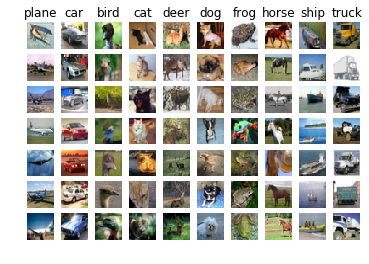

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [7]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


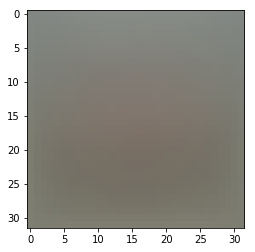

In [8]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [9]:
mean_image.shape

(3072,)

In [10]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [11]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [12]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.498742


In [74]:
W.shape

(3073, 10)

In [75]:
X_train[0].shape

(3073,)

In [76]:
X_train[0, :].shape

(3073,)

In [77]:
W[:, 0].shape

(3073,)

In [78]:
np.sum(W[:, 0])

-0.0034042688096951102

In [79]:
X_train[0, :].dot(W).shape

(10,)

The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -0.343250 analytic: -0.343250, relative error: 3.626950e-10
numerical: -5.646634 analytic: -5.646634, relative error: 4.725566e-12
numerical: 18.083128 analytic: 18.083128, relative error: 2.840402e-12
numerical: 0.545473 analytic: 0.545473, relative error: 1.358245e-10
numerical: 9.132418 analytic: 9.132418, relative error: 2.903088e-11
numerical: 4.164373 analytic: 4.164373, relative error: 6.085035e-11
numerical: -13.617564 analytic: -13.617564, relative error: 2.392484e-11
numerical: -9.258958 analytic: -9.258958, relative error: 2.140655e-11
numerical: 25.363100 analytic: 25.363100, relative error: 7.869924e-12
numerical: 14.407589 analytic: 14.407589, relative error: 1.134297e-14
numerical: -13.238851 analytic: -13.238851, relative error: 2.471350e-12
numerical: -5.970896 analytic: -5.970896, relative error: 2.537846e-12
numerical: 12.410081 analytic: 12.410081, relative error: 3.073628e-11
numerical: 21.015807 analytic: 21.015807, relative error: 7.637999e-12
numerica

In [11]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 5.115619 analytic: 5.115619, relative error: 3.742191e-11
numerical: 22.322871 analytic: 22.322871, relative error: 5.428412e-12
numerical: 5.697968 analytic: 5.697968, relative error: 6.835177e-11
numerical: -8.022954 analytic: -8.022954, relative error: 2.037553e-11
numerical: 24.505565 analytic: 24.505565, relative error: 1.635871e-11
numerical: 5.337023 analytic: 5.337023, relative error: 3.776065e-11
numerical: -24.713521 analytic: -24.713521, relative error: 1.320189e-11
numerical: -21.004052 analytic: -21.004052, relative error: 6.505202e-12
numerical: 1.117360 analytic: 1.117360, relative error: 3.717092e-10
numerical: 22.183441 analytic: 22.183441, relative error: 3.394173e-12
numerical: 10.996539 analytic: 10.996539, relative error: 9.629188e-12
numerical: -25.237018 analytic: -25.237018, relative error: 6.442448e-12
numerical: -8.829408 analytic: -8.829408, relative error: 4.170866e-11
numerical: 13.974524 analytic: 13.974524, relative error: 8.619914e-12
numerica

In [82]:
X_train.shape

(49000, 3073)

In [83]:
grad.shape

(3073, 10)

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [84]:
loss

9.088783479311989

In [85]:
X_dev.shape, W.shape

((500, 3073), (3073, 10))

In [86]:
dev_scores = X_dev.dot(W)
dev_scores.shape

(500, 10)

In [87]:
y_dev.shape

(500,)

In [88]:
print(dev_scores)
print()
print(y_dev)

[[ 0.02412801 -0.10490792 -0.09566448 ...  0.15512081  0.03586198
   0.09447325]
 [-0.11977176  0.58311752  0.57874427 ...  0.29008475  0.30251684
  -0.36989084]
 [ 0.47410413  0.33423409 -0.55892914 ...  0.86789039 -0.04094596
   0.00743969]
 ...
 [-0.03666511 -0.77086368 -0.60477119 ... -0.12577134 -0.10332934
   0.01498528]
 [-0.12732561  0.05955982 -0.34042569 ... -0.11835499  0.00798083
   0.43044772]
 [ 0.10929755  0.12149025  0.38504588 ... -0.2993071   0.10371778
  -0.08287555]]

[5 7 5 5 1 7 1 5 1 1 1 6 9 0 2 4 9 5 2 9 7 7 2 5 4 7 3 6 3 7 1 8 6 2 7 8 7
 6 2 3 7 5 3 3 0 0 7 9 2 0 7 8 8 1 2 4 2 1 0 7 6 4 2 8 4 4 8 1 8 3 9 1 6 5
 6 2 1 1 6 2 6 3 2 1 0 7 3 1 1 7 8 8 3 9 9 5 4 2 7 9 7 4 6 5 9 3 1 1 0 7 1
 3 0 2 5 3 7 7 5 2 5 7 8 9 0 9 3 3 7 1 0 9 4 1 1 2 4 4 1 8 7 1 7 4 4 8 3 4
 7 7 3 9 0 1 7 2 7 4 3 3 0 6 7 3 3 7 2 7 9 5 2 5 2 6 6 0 9 3 2 6 6 1 8 8 6
 1 1 2 7 8 2 2 2 4 4 0 3 1 2 0 9 0 5 3 3 6 6 7 2 1 3 2 3 7 1 0 1 7 9 5 2 6
 2 8 5 2 7 8 5 0 7 4 8 0 2 0 0 8 8 0 6 9 2 8 8 3 8 0 8 7 

In [89]:
dev_scores[0, y_dev[0]] # score of true class of first example

0.05601750566831573

In [90]:
dev_scores[[1, 2]]

array([[-0.11977176,  0.58311752,  0.57874427, -0.22378755, -0.42849807,
        -0.47057335, -0.06211   ,  0.29008475,  0.30251684, -0.36989084],
       [ 0.47410413,  0.33423409, -0.55892914, -0.21238343, -0.72405633,
        -0.26079581,  0.20316383,  0.86789039, -0.04094596,  0.00743969]])

In [91]:
print(dev_scores[:, np.newaxis])
print(dev_scores[:, np.newaxis].shape)

[[[ 0.02412801 -0.10490792 -0.09566448 ...  0.15512081  0.03586198
    0.09447325]]

 [[-0.11977176  0.58311752  0.57874427 ...  0.29008475  0.30251684
   -0.36989084]]

 [[ 0.47410413  0.33423409 -0.55892914 ...  0.86789039 -0.04094596
    0.00743969]]

 ...

 [[-0.03666511 -0.77086368 -0.60477119 ... -0.12577134 -0.10332934
    0.01498528]]

 [[-0.12732561  0.05955982 -0.34042569 ... -0.11835499  0.00798083
    0.43044772]]

 [[ 0.10929755  0.12149025  0.38504588 ... -0.2993071   0.10371778
   -0.08287555]]]
(500, 1, 10)


In [92]:
X_dev.shape

(500, 3073)

In [93]:
print(dev_scores[np.newaxis])
print(dev_scores[np.newaxis].shape)

[[[ 0.02412801 -0.10490792 -0.09566448 ...  0.15512081  0.03586198
    0.09447325]
  [-0.11977176  0.58311752  0.57874427 ...  0.29008475  0.30251684
   -0.36989084]
  [ 0.47410413  0.33423409 -0.55892914 ...  0.86789039 -0.04094596
    0.00743969]
  ...
  [-0.03666511 -0.77086368 -0.60477119 ... -0.12577134 -0.10332934
    0.01498528]
  [-0.12732561  0.05955982 -0.34042569 ... -0.11835499  0.00798083
    0.43044772]
  [ 0.10929755  0.12149025  0.38504588 ... -0.2993071   0.10371778
   -0.08287555]]]
(1, 500, 10)


In [94]:
print(dev_scores[:, :, np.newaxis])
print(dev_scores[:, :, np.newaxis].shape)

[[[ 0.02412801]
  [-0.10490792]
  [-0.09566448]
  ...
  [ 0.15512081]
  [ 0.03586198]
  [ 0.09447325]]

 [[-0.11977176]
  [ 0.58311752]
  [ 0.57874427]
  ...
  [ 0.29008475]
  [ 0.30251684]
  [-0.36989084]]

 [[ 0.47410413]
  [ 0.33423409]
  [-0.55892914]
  ...
  [ 0.86789039]
  [-0.04094596]
  [ 0.00743969]]

 ...

 [[-0.03666511]
  [-0.77086368]
  [-0.60477119]
  ...
  [-0.12577134]
  [-0.10332934]
  [ 0.01498528]]

 [[-0.12732561]
  [ 0.05955982]
  [-0.34042569]
  ...
  [-0.11835499]
  [ 0.00798083]
  [ 0.43044772]]

 [[ 0.10929755]
  [ 0.12149025]
  [ 0.38504588]
  ...
  [-0.2993071 ]
  [ 0.10371778]
  [-0.08287555]]]
(500, 10, 1)


In [95]:
rows = np.arange(dev_scores.shape[0])
columns = y_dev
true_class_scores = dev_scores[rows, columns]

In [96]:
true_class_scores.reshape(500,1)

array([[ 5.60175057e-02],
       [ 2.90084745e-01],
       [-2.60795812e-01],
       [ 5.84998886e-04],
       [-6.35261777e-02],
       [ 8.08191850e-02],
       [ 3.37385871e-01],
       [-5.25567859e-02],
       [ 2.36520579e-01],
       [ 5.39542698e-01],
       [-1.10495790e-01],
       [-3.60176765e-03],
       [ 4.47811800e-01],
       [-6.49206289e-01],
       [-7.06994188e-02],
       [-1.81806843e-01],
       [ 5.05896488e-01],
       [ 3.58671107e-01],
       [ 5.47934418e-01],
       [-8.72227943e-02],
       [ 1.42209155e-01],
       [-4.80752146e-02],
       [-1.90735138e-01],
       [-2.39678767e-01],
       [ 9.70380334e-02],
       [-3.75335236e-01],
       [ 5.57500339e-01],
       [ 1.16568283e-01],
       [-6.81623689e-01],
       [-1.66278398e-01],
       [ 2.28201188e-01],
       [ 3.72043041e-01],
       [ 1.32368496e+00],
       [-4.78663864e-01],
       [-6.56902621e-01],
       [-6.97533755e-02],
       [ 3.60280565e-01],
       [-3.16550186e-01],
       [-1.4

In [97]:
for i in range(dev_scores.shape[0]):
    if (dev_scores[i][y_dev[i]] == true_class_scores[i])==False:
        print("Wrong")  

In [98]:
margin_dev = np.clip(dev_scores - true_class_scores.reshape(500,1) + 1, a_min = 0, a_max = None)
margin_dev

array([[0.96811051, 0.83907458, 0.84831801, ..., 1.0991033 , 0.97984447,
        1.03845575],
       [0.5901435 , 1.29303277, 1.28865953, ..., 1.        , 1.0124321 ,
        0.34002441],
       [1.73489994, 1.5950299 , 0.70186667, ..., 2.1286862 , 1.21984986,
        1.2682355 ],
       ...,
       [1.56810608, 0.83390751, 1.        , ..., 1.47899985, 1.50144186,
        1.61975647],
       [0.62580582, 0.81269124, 0.41270573, ..., 0.63477643, 0.76111225,
        1.18357915],
       [1.40860465, 1.42079734, 1.68435298, ..., 1.        , 1.40302488,
        1.21643155]])

In [99]:
margin_dev[rows,columns] = 0
margin_dev

array([[0.96811051, 0.83907458, 0.84831801, ..., 1.0991033 , 0.97984447,
        1.03845575],
       [0.5901435 , 1.29303277, 1.28865953, ..., 0.        , 1.0124321 ,
        0.34002441],
       [1.73489994, 1.5950299 , 0.70186667, ..., 2.1286862 , 1.21984986,
        1.2682355 ],
       ...,
       [1.56810608, 0.83390751, 0.        , ..., 1.47899985, 1.50144186,
        1.61975647],
       [0.62580582, 0.81269124, 0.41270573, ..., 0.63477643, 0.76111225,
        1.18357915],
       [1.40860465, 1.42079734, 1.68435298, ..., 0.        , 1.40302488,
        1.21643155]])

In [100]:
margin_dev.sum()/dev_scores.shape[0]

9.073307498249568

In [101]:
(margin_dev < 0).sum()

0

In [102]:
X_dev.shape, W.shape

((500, 3073), (3073, 10))

In [103]:
print(margin_dev)
print(margin_dev.shape)

[[0.96811051 0.83907458 0.84831801 ... 1.0991033  0.97984447 1.03845575]
 [0.5901435  1.29303277 1.28865953 ... 0.         1.0124321  0.34002441]
 [1.73489994 1.5950299  0.70186667 ... 2.1286862  1.21984986 1.2682355 ]
 ...
 [1.56810608 0.83390751 0.         ... 1.47899985 1.50144186 1.61975647]
 [0.62580582 0.81269124 0.41270573 ... 0.63477643 0.76111225 1.18357915]
 [1.40860465 1.42079734 1.68435298 ... 0.         1.40302488 1.21643155]]
(500, 10)


In [104]:
W.shape

(3073, 10)

dW = 
* (example, row, class number)
* (slice, row, column)

In [105]:
rows = np.arange(dev_scores.shape[0])
columns = y_dev
true_class_scores = dev_scores[rows, columns]

In [106]:
dW = np.zeros((500, 3073, 10))
dW.shape
reg = 0.000005
#this is columns of true class for each example
print(dW[rows, :, columns])
print(dW[rows, :, columns].shape)
fmargin_count = np.sum(margin_dev > 0, axis = 1).reshape(np.sum(margin_dev > 0, axis = 1).shape[0], 1) #failed margin number for each example
print("fmargin_count.shape", fmargin_count.shape)
trueclass_reg = 2*reg*(np.sum(W[:, columns], axis = 0).reshape(500, 1))
print(trueclass_reg.shape)
dW[rows, :, columns] = -fmargin_count*X_dev + trueclass_reg

#failed margins
reg = 0.000005
fmargin_row, fmargin_column = np.where(margin_dev > 0) # rows and columns of failed margin
dW[fmargin_row, :, fmargin_column].shape
fmargin_reg = 2*reg*np.sum(W[:, fmargin_column], axis = 1)
dW[fmargin_row, :, fmargin_column] = X_dev[fmargin_row] + fmargin_reg

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(500, 3073)
fmargin_count.shape (500, 1)
(500, 1)


In [107]:
dW = np.zeros(W.shape)

In [108]:
margin_dev

array([[0.96811051, 0.83907458, 0.84831801, ..., 1.0991033 , 0.97984447,
        1.03845575],
       [0.5901435 , 1.29303277, 1.28865953, ..., 0.        , 1.0124321 ,
        0.34002441],
       [1.73489994, 1.5950299 , 0.70186667, ..., 2.1286862 , 1.21984986,
        1.2682355 ],
       ...,
       [1.56810608, 0.83390751, 0.        , ..., 1.47899985, 1.50144186,
        1.61975647],
       [0.62580582, 0.81269124, 0.41270573, ..., 0.63477643, 0.76111225,
        1.18357915],
       [1.40860465, 1.42079734, 1.68435298, ..., 0.        , 1.40302488,
        1.21643155]])

In [109]:
print("X_dev shape",X_dev.shape)
print("margin_dev shape", margin_dev.shape)
print("y_dev shape", y_dev.shape) # columns
print("rows shape", rows.shape) # example
print("true class scores", true_class_scores.shape)
print("dW shape", dW.shape)

X_dev shape (500, 3073)
margin_dev shape (500, 10)
y_dev shape (500,)
rows shape (500,)
true class scores (500,)
dW shape (3073, 10)


In [110]:
#print(X_dev) # each row corresponds to individual image
#print()
#print(X_dev.T) 
print("X_dev.T shape", X_dev.T.shape) 
#each row corresponds to one pixel of image. 
#first row is combination of first pixels of images.

X_dev.T shape (3073, 500)


In [111]:
margin_dev.shape #each row corresponds to score of the classes that classified correctly or not.
                 #each column corresponds to whether an example classified correctly or not regarding a specific class.
                 # 1 is false, 0 is true
                 #except true class. It can be bigger than 1.

(500, 10)

In [112]:
X_dev.T.dot(margin_dev).shape # Each row explains how a pixel of image affect the classifier regarding different templates
                              # Which means it is equal to dW

(3073, 10)

In [113]:
margin_dev

array([[0.96811051, 0.83907458, 0.84831801, ..., 1.0991033 , 0.97984447,
        1.03845575],
       [0.5901435 , 1.29303277, 1.28865953, ..., 0.        , 1.0124321 ,
        0.34002441],
       [1.73489994, 1.5950299 , 0.70186667, ..., 2.1286862 , 1.21984986,
        1.2682355 ],
       ...,
       [1.56810608, 0.83390751, 0.        , ..., 1.47899985, 1.50144186,
        1.61975647],
       [0.62580582, 0.81269124, 0.41270573, ..., 0.63477643, 0.76111225,
        1.18357915],
       [1.40860465, 1.42079734, 1.68435298, ..., 0.        , 1.40302488,
        1.21643155]])

In [114]:
margin_dev = np.clip(dev_scores - true_class_scores.reshape(500,1) + 1, a_min = 0, a_max = None)
margin_dev[rows, columns] = 0
dw_margin_dev = np.asarray((margin_dev > 0), dtype=int)
fmargin_perexample = (dw_margin_dev).sum(axis=1) #total number of failed margins per example
dw_margin_dev[rows, columns]  = -fmargin_perexample
dw_margin_dev

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ..., -9,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [ 1,  1, -9, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ..., -9,  1,  1]])

In [115]:
X_dev.shape[0]

500

In [116]:
(X_dev.T.dot(dw_margin_dev) + 2*reg*np.sum(W, axis=0))/500

array([[-2.13927162e+01,  1.48982167e+01, -8.52436347e+00, ...,
        -1.11564727e+00, -2.59998657e+01, -3.13090152e+01],
       [-3.35100365e+01,  1.52486849e+01, -1.07422010e+01, ...,
        -3.86164490e-01, -3.62454429e+01, -3.12188492e+01],
       [-5.24050522e+01,  9.54412212e+00,  3.92700122e+00, ...,
         1.20205339e+00, -5.44743486e+01, -3.46716450e+01],
       ...,
       [-8.61827608e+00, -2.82793894e+00, -1.24677494e+01, ...,
         1.08865267e+01,  4.54532571e+00, -1.32010725e+01],
       [-2.06812009e+01, -1.05832309e+01, -6.09809857e+00, ...,
         2.86591023e+01, -9.71394000e+00, -1.80226791e+01],
       [-2.00000007e-03, -7.20000001e-02, -2.30000000e-01, ...,
        -2.28000000e-01,  1.40000000e-01,  2.82000000e-01]])

In [117]:
W.sum(axis=1).shape

(3073,)

In [118]:
dW.shape

(3073, 10)

In [119]:
(margin_dev == 0).sum()

613

In [120]:
(margin_dev > 0)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False,  True,  True]])

In [121]:
W.shape

(3073, 10)

In [122]:
margin_dev.shape

(500, 10)

In [123]:
#gradient of false class
dW_raw = X_dev.T.dot(margin_dev > 0)

dW_reg = 2*reg*np.sum(W, axis=1)

In [124]:
dW.shape

(3073, 10)

In [125]:
dW.shape

(3073, 10)

In [126]:
W.sum(axis=0).shape

(10,)

In [127]:
W.sum(axis=0) + dW

array([[-0.00340427, -0.00302595, -0.00840283, ...,  0.00721585,
        -0.00232057, -0.00286294],
       [-0.00340427, -0.00302595, -0.00840283, ...,  0.00721585,
        -0.00232057, -0.00286294],
       [-0.00340427, -0.00302595, -0.00840283, ...,  0.00721585,
        -0.00232057, -0.00286294],
       ...,
       [-0.00340427, -0.00302595, -0.00840283, ...,  0.00721585,
        -0.00232057, -0.00286294],
       [-0.00340427, -0.00302595, -0.00840283, ...,  0.00721585,
        -0.00232057, -0.00286294],
       [-0.00340427, -0.00302595, -0.00840283, ...,  0.00721585,
        -0.00232057, -0.00286294]])

In [128]:
margin_dev > 0

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False,  True,  True]])

In [129]:
W.shape

(3073, 10)

In [130]:
X_dev*

SyntaxError: invalid syntax (<ipython-input-130-8a3e76ca33e0>, line 1)

In [131]:
#should find derivative for each row
#should take average of them
#This failed
#I should try to find dW with matrix multiplication(dot)

In [132]:
np.random.seed(18)

In [12]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.207597e+00 computed in 0.108464s
Vectorized loss: 9.207597e+00 computed in 0.003442s
difference: -0.000000


In [13]:
print(loss_naive )
print(loss_vectorized)

9.207596773604703
9.20759677360471


In [14]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.107873s
Vectorized loss and gradient: computed in 0.002785s
difference: 0.000000


In [136]:
W.shape

(3073, 10)

In [15]:
grad_naive[0]

array([-19.5588111 ,   3.99502776,  14.50408237,   9.85439212,
        15.43067502,   7.66644584,  11.58833841,  -0.68282543,
        -5.75027037, -37.04705461])

In [16]:
grad_vectorized[0]

array([-19.5588111 ,   3.99502776,  14.50408237,   9.85439212,
        15.43067502,   7.66644584,  11.58833841,  -0.68282543,
        -5.75027037, -37.04705461])

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [139]:
X_dev.shape

(500, 3073)

In [140]:
batch_indices = np.random.choice(X_dev.shape[0], 100, replace = False)
batch_indices

array([207, 239,   1, 103, 177, 483, 217, 448, 344, 218, 181,  97, 225,
       289, 223, 368, 235, 236, 490, 179, 271,  98, 176, 246, 304, 286,
        29, 166, 366,  25, 456, 126, 306, 375, 272, 229, 251, 238, 372,
       478,  38, 154, 311, 227, 411, 163,  30,  47, 430,   6, 447, 134,
         8, 260, 482, 295,  51, 351, 346, 382,  74, 425, 230, 484, 123,
         0, 189, 299, 343, 221, 476, 137,  10, 198, 378,  33,  26, 241,
       320,  69, 438, 462, 252,  39, 165, 431, 432,  91, 364, 302, 332,
       121, 459, 454, 183, 143, 355, 216,  18,  52])

In [141]:
X_dev[batch_indices], y_dev[batch_indices]

(array([[-47.64189796, -56.98173469, -54.47391837, ..., -26.86195918,
         -19.39957143,   1.        ],
        [ 10.35810204,   2.01826531,   0.52608163, ...,  92.13804082,
          95.60042857,   1.        ],
        [ 65.35810204,  37.01826531,  15.52608163, ..., -41.86195918,
         -77.39957143,   1.        ],
        ...,
        [ 39.35810204,  69.01826531, 104.52608163, ..., -31.86195918,
           3.60042857,   1.        ],
        [ 48.35810204,  22.01826531, -22.47391837, ..., -84.86195918,
         -83.39957143,   1.        ],
        [-57.64189796, -30.98173469,  -5.47391837, ..., -71.86195918,
         -59.39957143,   1.        ]]),
 array([7, 0, 7, 5, 3, 5, 7, 4, 1, 9, 1, 2, 2, 4, 8, 6, 0, 0, 2, 6, 6, 7,
        9, 8, 6, 4, 7, 2, 8, 7, 6, 3, 1, 5, 3, 0, 1, 8, 5, 8, 2, 7, 7, 8,
        0, 3, 1, 9, 4, 1, 0, 1, 1, 8, 1, 0, 8, 4, 1, 2, 6, 7, 7, 2, 9, 5,
        8, 1, 1, 6, 3, 4, 1, 2, 9, 2, 3, 9, 0, 3, 0, 8, 7, 3, 7, 4, 2, 8,
        6, 7, 2, 7, 8, 5, 8, 4, 6, 1, 2, 

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 779.338596
iteration 100 / 1500: loss 284.296294
iteration 200 / 1500: loss 107.408120
iteration 300 / 1500: loss 42.138825
iteration 400 / 1500: loss 18.301735
iteration 500 / 1500: loss 10.345407
iteration 600 / 1500: loss 7.274573
iteration 700 / 1500: loss 5.823937
iteration 800 / 1500: loss 5.366254
iteration 900 / 1500: loss 5.355411
iteration 1000 / 1500: loss 5.877631
iteration 1100 / 1500: loss 5.015408
iteration 1200 / 1500: loss 5.229683
iteration 1300 / 1500: loss 5.473119
iteration 1400 / 1500: loss 5.541442
That took 5.444649s


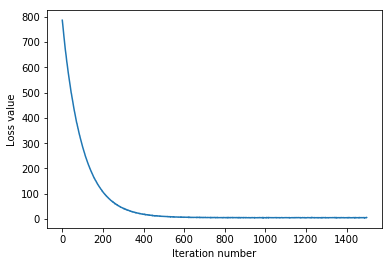

In [18]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [144]:
X_dev.shape, svm.W.shape

((500, 3073), (3073, 10))

In [145]:
np.argmax(X_dev.dot(svm.W), axis=1)

array([4, 7, 0, 6, 9, 2, 1, 3, 1, 1, 5, 1, 9, 3, 2, 1, 8, 3, 6, 9, 3, 7,
       4, 1, 4, 1, 5, 6, 3, 9, 9, 8, 2, 4, 7, 9, 0, 6, 8, 3, 2, 2, 8, 9,
       0, 0, 5, 9, 8, 1, 0, 8, 2, 1, 8, 2, 1, 1, 8, 7, 2, 0, 4, 8, 6, 6,
       1, 9, 9, 5, 3, 1, 6, 8, 6, 6, 6, 6, 6, 2, 6, 2, 2, 9, 5, 3, 3, 3,
       4, 5, 8, 9, 0, 1, 9, 5, 0, 4, 9, 9, 2, 7, 6, 5, 9, 3, 0, 1, 8, 7,
       1, 6, 0, 2, 2, 9, 2, 7, 3, 0, 7, 5, 1, 0, 0, 8, 6, 0, 8, 1, 5, 9,
       7, 1, 9, 7, 3, 4, 5, 8, 2, 5, 6, 4, 3, 8, 0, 5, 7, 9, 9, 9, 9, 8,
       4, 3, 7, 0, 6, 7, 8, 4, 7, 9, 3, 9, 4, 7, 9, 2, 4, 3, 9, 5, 0, 7,
       9, 4, 2, 0, 3, 3, 4, 9, 5, 1, 6, 6, 7, 8, 9, 2, 5, 6, 4, 0, 5, 9,
       4, 3, 0, 8, 3, 2, 5, 9, 7, 5, 5, 1, 2, 2, 0, 2, 8, 0, 3, 4, 9, 5,
       8, 1, 2, 0, 4, 1, 5, 9, 5, 0, 3, 3, 0, 8, 6, 5, 9, 8, 1, 2, 6, 8,
       7, 9, 0, 1, 8, 0, 8, 5, 6, 9, 2, 8, 6, 2, 5, 9, 9, 2, 8, 0, 6, 3,
       8, 9, 8, 5, 5, 0, 9, 6, 6, 9, 1, 2, 7, 6, 0, 8, 6, 6, 3, 1, 2, 1,
       6, 3, 4, 2, 6, 2, 1, 2, 6, 8, 8, 1, 1, 9, 6,

In [14]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.368388
validation accuracy: 0.391000


In [147]:
1e4*0.8

8000.0

In [148]:
1e4

10000.0

In [149]:
3e-4

0.0003

In [150]:
float(7e-7), 3e-7, 1e-6

(7e-07, 3e-07, 1e-06)

In [19]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
#learning_rates = [1e-7, 5e-5]
#regularization_strengths = [2.5e4, 5e4, 2e3]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
#learning_rates = [5e-5, 1e-5, 1e-6, 3e-6]
#regularization_strengths = [1e4, 1e4*0.8, 5e5, 1e3]

learning_rates = [1e-7, 2e-7, 3e-7, 5e-7, 8e-7]
regularization_strengths = [1e2, 3e2, 4e2, 5e2, 8e2, 1e3, 2e3, 3e3]
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                              num_iters=1200, verbose=True) 
        y_train_pred = svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        valid_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accuracy, valid_accuracy)
        if valid_accuracy > best_val:
            best_val = valid_accuracy
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1200: loss 23.663447
iteration 100 / 1200: loss 14.143688
iteration 200 / 1200: loss 12.572824
iteration 300 / 1200: loss 11.703810
iteration 400 / 1200: loss 11.985603
iteration 500 / 1200: loss 10.989942
iteration 600 / 1200: loss 10.665970
iteration 700 / 1200: loss 9.415000
iteration 800 / 1200: loss 8.952449
iteration 900 / 1200: loss 10.098067
iteration 1000 / 1200: loss 10.131286
iteration 1100 / 1200: loss 10.328721
iteration 0 / 1200: loss 29.265971
iteration 100 / 1200: loss 20.012654
iteration 200 / 1200: loss 17.744315
iteration 300 / 1200: loss 17.641298
iteration 400 / 1200: loss 17.281521
iteration 500 / 1200: loss 16.481634
iteration 600 / 1200: loss 16.365625
iteration 700 / 1200: loss 15.636179
iteration 800 / 1200: loss 14.993759
iteration 900 / 1200: loss 14.793428
iteration 1000 / 1200: loss 13.606585
iteration 1100 / 1200: loss 14.499829
iteration 0 / 1200: loss 36.080667
iteration 100 / 1200: loss 23.640057
iteration 200 / 1200: loss 21.502790
itera

iteration 600 / 1200: loss 15.261889
iteration 700 / 1200: loss 13.500646
iteration 800 / 1200: loss 13.652002
iteration 900 / 1200: loss 12.811440
iteration 1000 / 1200: loss 12.067037
iteration 1100 / 1200: loss 11.773398
iteration 0 / 1200: loss 38.208895
iteration 100 / 1200: loss 23.603797
iteration 200 / 1200: loss 20.880142
iteration 300 / 1200: loss 18.882221
iteration 400 / 1200: loss 17.659335
iteration 500 / 1200: loss 17.189567
iteration 600 / 1200: loss 17.267759
iteration 700 / 1200: loss 15.389962
iteration 800 / 1200: loss 14.569275
iteration 900 / 1200: loss 14.167670
iteration 1000 / 1200: loss 12.818544
iteration 1100 / 1200: loss 12.889969
iteration 0 / 1200: loss 47.898320
iteration 100 / 1200: loss 30.615112
iteration 200 / 1200: loss 27.797278
iteration 300 / 1200: loss 25.743287
iteration 400 / 1200: loss 21.637207
iteration 500 / 1200: loss 21.178378
iteration 600 / 1200: loss 18.821227
iteration 700 / 1200: loss 16.545881
iteration 800 / 1200: loss 15.361141
i

iteration 200 / 1200: loss 21.153890
iteration 300 / 1200: loss 15.546309
iteration 400 / 1200: loss 13.800778
iteration 500 / 1200: loss 11.958024
iteration 600 / 1200: loss 8.447826
iteration 700 / 1200: loss 8.083877
iteration 800 / 1200: loss 6.378323
iteration 900 / 1200: loss 6.406141
iteration 1000 / 1200: loss 5.862733
iteration 1100 / 1200: loss 5.973525
iteration 0 / 1200: loss 79.410001
iteration 100 / 1200: loss 38.173186
iteration 200 / 1200: loss 22.147417
iteration 300 / 1200: loss 13.949941
iteration 400 / 1200: loss 9.135781
iteration 500 / 1200: loss 7.592648
iteration 600 / 1200: loss 6.799423
iteration 700 / 1200: loss 7.170339
iteration 800 / 1200: loss 5.293309
iteration 900 / 1200: loss 4.946207
iteration 1000 / 1200: loss 4.533902
iteration 1100 / 1200: loss 5.305446
iteration 0 / 1200: loss 113.780160
iteration 100 / 1200: loss 40.395383
iteration 200 / 1200: loss 18.050047
iteration 300 / 1200: loss 10.357739
iteration 400 / 1200: loss 6.582411
iteration 500 /

In [ ]:
# lr 8.000000e-07 reg 4.000000e+02 train accuracy: 0.371551 val accuracy: 0.397000

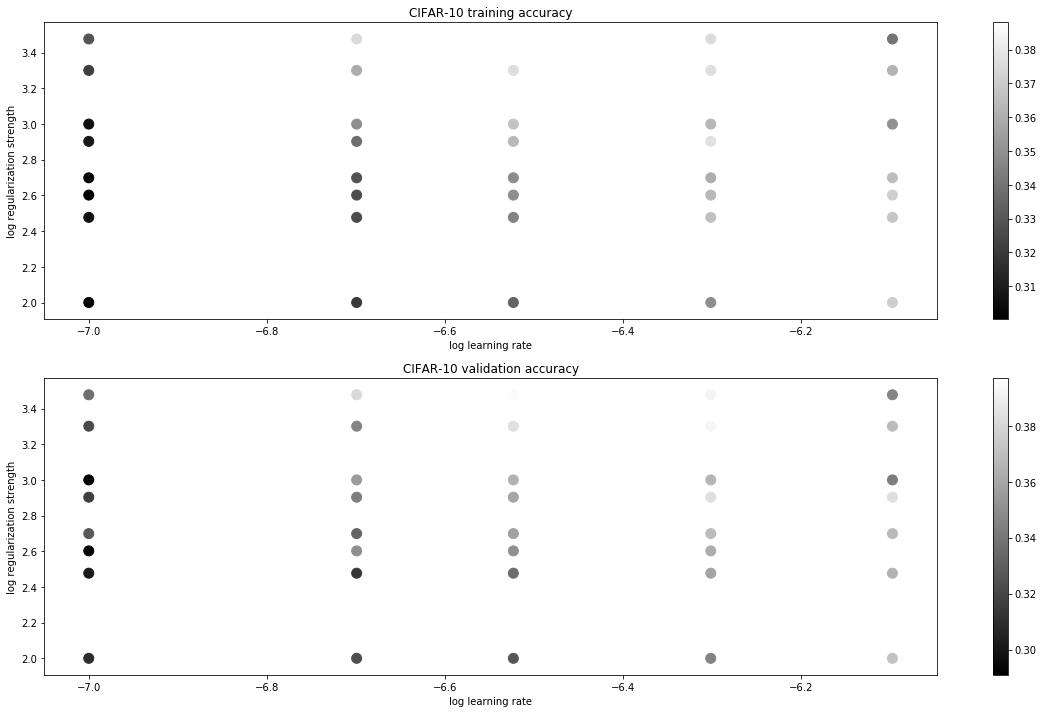

In [20]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

plt.rcParams['figure.figsize'] = (20.0, 12.0)

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [21]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.370000


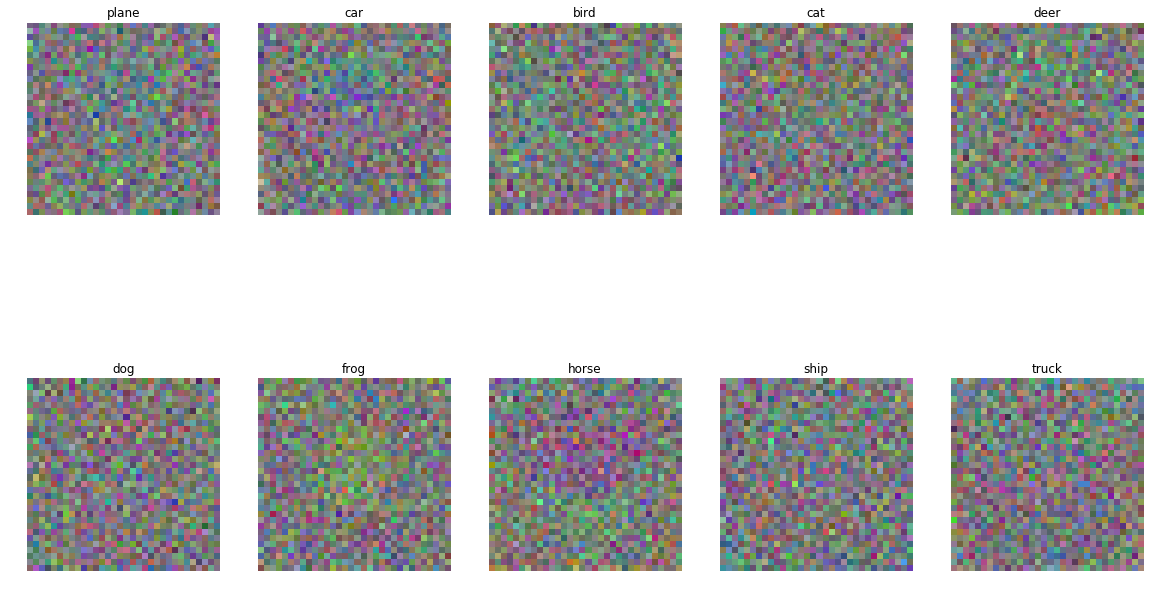

In [22]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

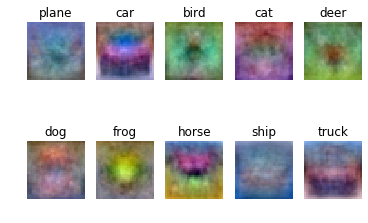

In [15]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*